# Modeling Extremes - From Scratch

In this example, we will look at how we can use the `scipy` library to learn relevan distributions for extreme values, i.e., GEVD.

In [28]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [29]:
data_url = "https://raw.githubusercontent.com/georgebv/pyextremes-notebooks/master/data/battery_wl.csv"

data = pd.read_csv(data_url, index_col=0, parse_dates=True).squeeze()
data.describe()

count    809903.000000
mean         -0.119026
std           0.533992
min          -2.122000
25%          -0.558000
50%          -0.111000
75%           0.316000
max           3.417000
Name: Water Elevation [m NAVD88], dtype: float64

## Clean Data

In [30]:
# sort ascending
data = data.sort_index(ascending=True)
# change type
data = data.astype(float)
# drop all nana
data = data.dropna()
# select start time - 1925
data = data.loc[pd.to_datetime("1925"):]
# rescale time
data = data  - (data.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3

data.describe()

count    796751.000000
mean         -0.063809
std           0.526933
min          -2.081901
25%          -0.498731
50%          -0.058581
75%           0.373429
max           3.357218
Name: Water Elevation [m NAVD88], dtype: float64

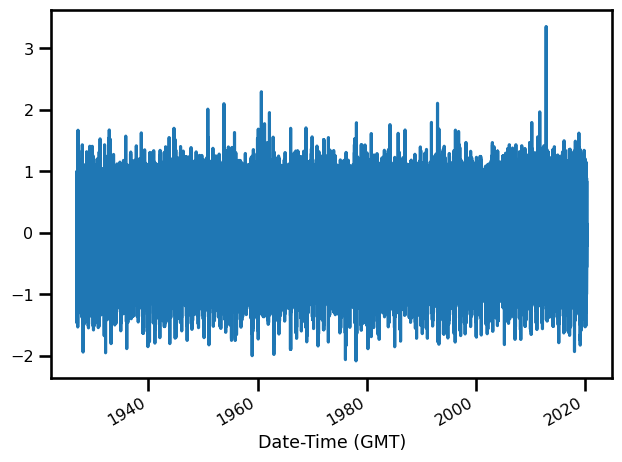

In [31]:
fig, ax = plt.subplots()

data.plot(ax=ax)

plt.tight_layout()
plt.show()

## Extremes

In [32]:
extremes_method = "BM"
block_size = "365.2425D"
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

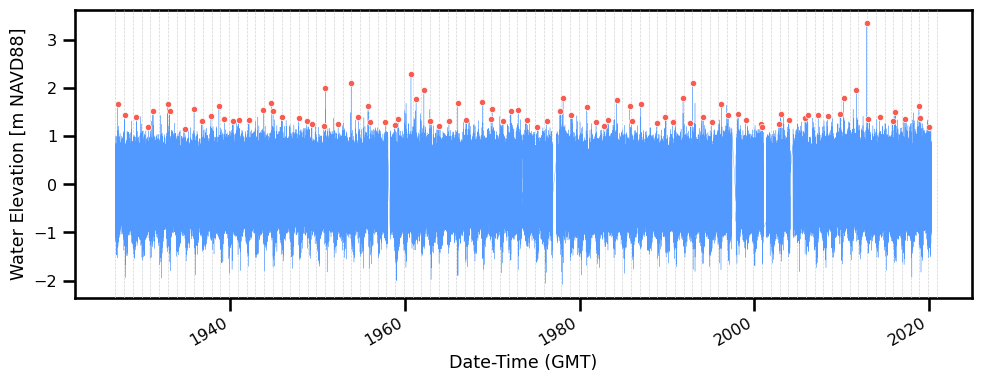

In [33]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

## Model

We will use the GEVD as our model.
The `scipy.stats` library has a `genextreme` distribution which has all of the functionality we need.
It also has built-in method to learn the parameters using the MLE method.

**Resources**:
* Scipy GEV - [scipy docs]()
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [121]:
# fit parameters to data
params = genextreme.fit(extremes, method="MLE")
model = genextreme(*params)
print("Parameters (MLE):")
print(f"Shape - ξ: {params[0]:.4f}")
print(f"Loc   - μ: {params[1]:.4f}")
print(f"Scale - σ: {params[2]:.4f}")

Parameters (MLE):
Shape - ξ: -0.2657
Loc   - μ: 1.3530
Scale - σ: 0.1463


## Diagnostics: Goodness of Fit

**Null Hypothesis**: *The distribution of the independent samples is identical to the specified cumulative distribution*.

If the statistic is small or the p-value is high, then we accept the null hypothesis.

In [58]:
from scipy.stats import kstest

In [62]:
out = kstest(extremes, model.cdf)
print(f"Kolmogorov-Smirnov Test")
print(f"Statistic: {out.statistic:.4f}")
print(f"P-Value: {out.pvalue:.4f}")

Kolmogorov-Smirnov Test
Statistic: 0.0531
P-Value: 0.9411


We **accept** the null hypothesis.

### Viz I: CDF

In [105]:
# create a length of the domain
x_domain = np.linspace(extremes.min(), extremes.max(), 100)
# get the PDF of the distribution
y_pdf = genextreme.pdf(x_domain, *params)

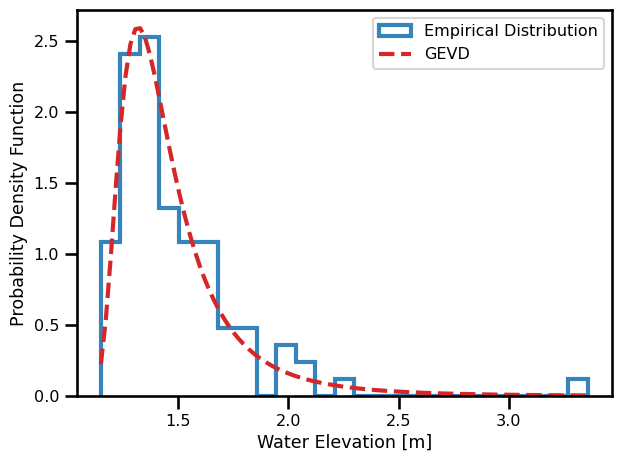

In [107]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=False, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_pdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Water Elevation [m]",
    ylabel="Probability Density Function",
)
plt.tight_layout()
plt.legend()
plt.show()

### Viz II: PDF

In [54]:
# get the CDF of the distribution
y_cdf = genextreme.cdf(x_domain, *params)

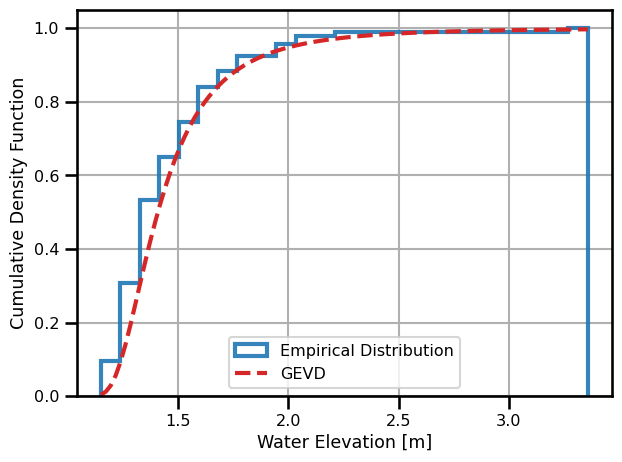

In [108]:
fig, ax = plt.subplots()

ax.hist(extremes, bins=25, rwidth=2, alpha=0.9, cumulative=True, density=True, color="tab:blue", linewidth=3, histtype="step", label="Empirical Distribution")
ax.plot(x_domain, y_cdf, linewidth=3, linestyle="--", color="tab:red", label="GEVD")

ax.set(
    xlabel="Water Elevation [m]",
    ylabel="Cumulative Density Function",
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.legend()
plt.show()

## Return Period

A major goal of the EVT is to estimate the extreme values corresponding to some return periods.
In other words, we want to know the relationship between the non-exceedence probability and the return periods.
This relationship is given by:

$$
p(X\leq x_T) = \frac{1}{T}
$$

where $x_T$ is the extreme annual water elevation corresponding to the return period of $T$.

**Resources**:
* Return Values from GEV - [StackOverFlow](https://stackoverflow.com/questions/71202562/calculating-return-value-using-generalised-extreme-value-distribution-gev)

In [86]:
# simple return periods
return_periods = np.logspace(-1, 3,20) #np.array([1, 10, 100, 1_000])
# calculate
return_levels = genextreme.isf(1/return_periods, *params)

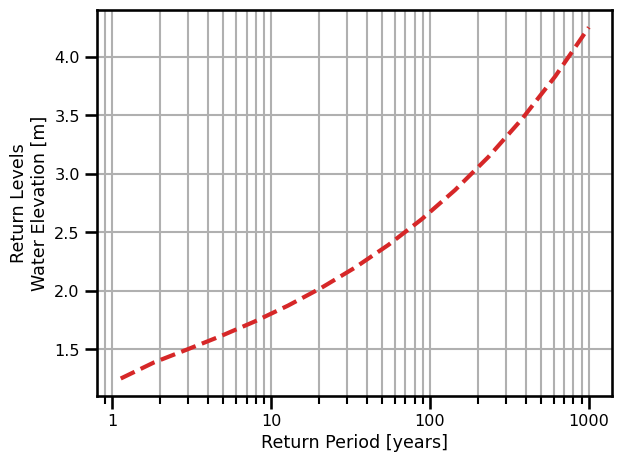

In [109]:

fig, ax = plt.subplots()

ax.plot(return_periods, return_levels, linestyle="--", linewidth=3, color="tab:red")

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels\nWater Elevation [m]",
    xscale="log",
)
# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()